# UTS Model Deployment 1A

## Nadja Nayara Krisna - 2702320425

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

## Data Overview

In [2]:
df=pd.read_csv('Dataset_A_loan.csv',delimiter=',')

In [3]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [4]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

### Look for missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   42750 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

From looking at df.info() output, we know that the 'person_income ' Column has NaN values because out of 45000 entries, only 42750 are counted as Non-Null.

### Look for unstardardized values

We are going to look at the value counts of each column. This is to overview if there are any unstandardized values or anomalies.

In [6]:
for column in df:
    print(df[column].value_counts())
    print("-" * 30)

person_age
23.0     5254
24.0     5138
25.0     4507
22.0     4236
26.0     3659
27.0     3095
28.0     2728
29.0     2455
30.0     2021
31.0     1645
32.0     1403
21.0     1289
33.0     1240
34.0      980
35.0      847
36.0      740
37.0      666
38.0      503
39.0      389
40.0      349
41.0      303
42.0      247
43.0      215
44.0      177
45.0      135
46.0      114
47.0      112
48.0       93
49.0       59
50.0       56
51.0       46
52.0       42
53.0       35
54.0       24
55.0       24
58.0       20
56.0       20
57.0       17
20.0       17
60.0       16
61.0       12
66.0       11
65.0       10
70.0        7
64.0        7
62.0        7
59.0        6
69.0        5
144.0       3
73.0        3
63.0        3
123.0       2
78.0        1
94.0        1
80.0        1
84.0        1
76.0        1
67.0        1
116.0       1
109.0       1
Name: count, dtype: int64
------------------------------
person_gender
male       24799
female     20111
Male          45
fe male       45
Name: coun

It turns out there is unstandardized values in person_gender column, where there is 'fe male' and 'Male', instead of 'female' and 'male'.

### Boxplot for outliers

We will generate boxplots for all numerical columns to visualize the data distribution and determine the appropriate next steps in the preprocessing phase, such as encoding and imputing.

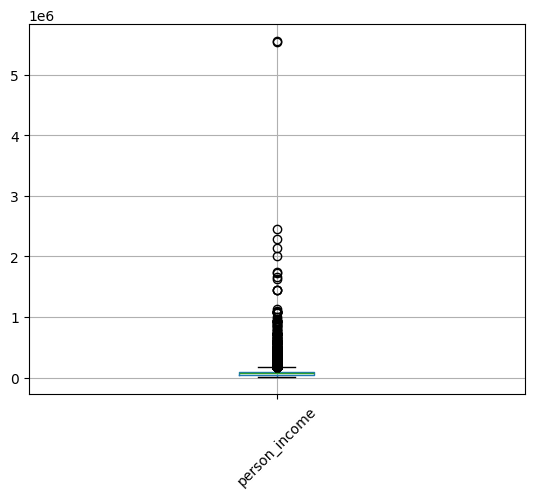

In [7]:
boxplot = df.boxplot(column=['person_income'])
plt.xticks(rotation=45)
plt.show()

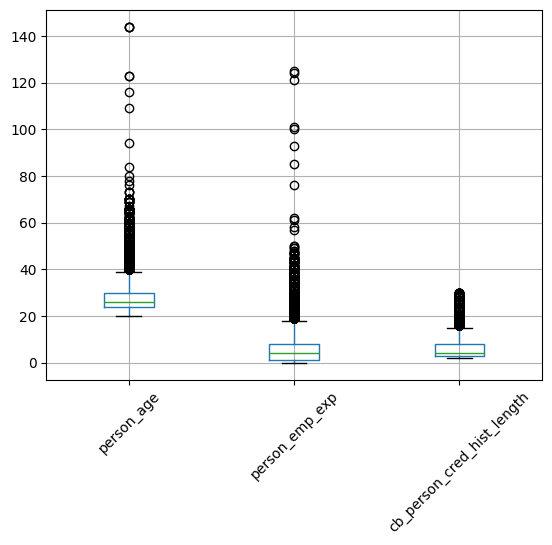

In [8]:
boxplot = df.boxplot(column=['person_age', 'person_emp_exp', 'cb_person_cred_hist_length'])
plt.xticks(rotation=45)
plt.show()

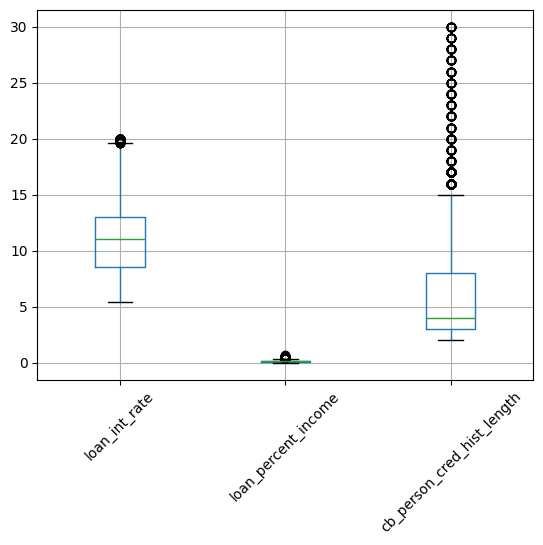

In [9]:
boxplot = df.boxplot(column=['loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length'])
plt.xticks(rotation=45)
plt.show()

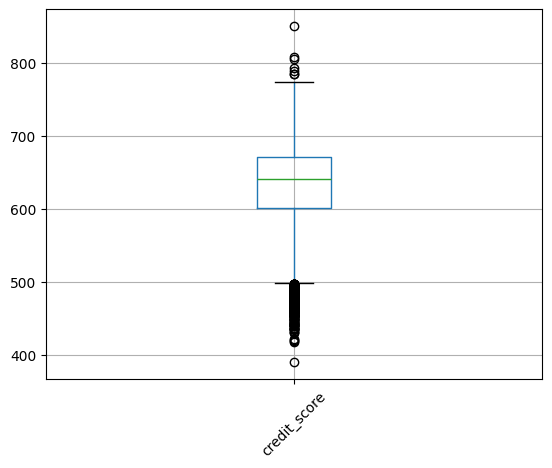

In [10]:
boxplot = df.boxplot(column=['credit_score'])
plt.xticks(rotation=45)
plt.show()

The boxplots shows that many of the numerical columns contain numerous outliers. However, since we are using Random Forest and XGBoost as our modeling algorithms, these outliers are not a major concern. This is because both Random Forest and XGBoost are tree-based models that split data at specific values (e.g., "Is income > 50K?") rather than being affected by how far a value is from the mean or median. They don't assume a normal distribution and don't use equations that are sensitive to large numerical deviations.As a result, they are robust to outliers, as extreme values do not significantly influence the decision boundaries of the trees.

## Data Splitting

Before handling the anomalies identified during the data overview, we must first split the dataset into training and testing sets to prevent data leakage. Data leakage can happen when information from outside the training dataset is unintentionally used to create the model. This undermines the model's ability to generalize, because it has indirectly "seen" the test data, leading to overly optimistic performance metrics and poor generalization to new, unseen data.

Because loan_status is the target variable, we will drop the column from x.

In [12]:
x = df.drop(columns=['loan_status'])
y = df['loan_status']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
x_train.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
25180,34.0,female,Bachelor,97265.0,11,MORTGAGE,15000.0,PERSONAL,12.73,0.15,9.0,631,No
12555,25.0,male,High School,NaN,3,RENT,12000.0,VENTURE,11.86,0.16,4.0,659,Yes
29153,41.0,female,Master,322597.0,18,MORTGAGE,24000.0,PERSONAL,10.37,0.07,11.0,683,Yes
23838,27.0,male,Associate,94232.0,4,RENT,9600.0,EDUCATION,17.14,0.10,7.0,641,No
35686,27.0,male,Master,NaN,7,RENT,7059.0,HOMEIMPROVEMENT,12.97,0.08,3.0,706,Yes


## Findings from data overview

#### person_gender

The column contains unstandardized values such as "fe male" and "Male", causing inconsistencies in the data. Since the majority of entries are correctly labeled as "female" and "male", we will standardize the inconsistent values to match the correct format. This ensures data uniformity, which is essential for accurate encoding and model interpretation.

In [15]:
x_train['person_gender'] = x_train['person_gender'].replace('fe male', 'female')
x_train['person_gender'] = x_train['person_gender'].replace('Male', 'male')
x_test['person_gender'] = x_test['person_gender'].replace('fe male', 'female')
x_test['person_gender'] = x_test['person_gender'].replace('Male', 'male')

In [16]:
x_train['person_gender'].value_counts()

person_gender
male      19817
female    16183
Name: count, dtype: int64

In [17]:
x_test['person_gender'].value_counts()

person_gender
male      5027
female    3973
Name: count, dtype: int64

#### person_age and person_emp_exp

From the boxplot and data types, we can see that there are age values above 100. We are going to inspect these entries more closely before deciding on the appropriate action.

In [18]:
more100 = x_train[x_train['person_age'] > 100]
more100

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
81,144.0,male,Bachelor,300616.0,125,RENT,4800.0,VENTURE,13.57,0.02,3.0,789,No
575,123.0,female,High School,97140.0,101,RENT,20400.0,EDUCATION,10.25,0.21,3.0,805,Yes
38113,109.0,male,High School,5556399.0,85,MORTGAGE,6195.0,VENTURE,12.58,0.00,22.0,792,No
32297,144.0,female,Associate,NaN,124,MORTGAGE,5000.0,PERSONAL,12.73,0.00,25.0,850,No
183,144.0,male,Associate,241424.0,121,MORTGAGE,6000.0,EDUCATION,11.86,0.02,2.0,807,No
37930,116.0,male,Bachelor,5545545.0,93,MORTGAGE,3823.0,VENTURE,12.15,0.00,24.0,708,No


It turns out that there are only 6 individuals with age values greater than 100. Interestingly, these entries also have employment experience values close to or exceeding 100, which is highly unrealistic and likely the result of data entry errors.

We have two options:
1. Impute the values using the median, which is more appropriate in this case because the boxplot indicates many outliers, making the median a better measure of central tendency than the mean, as it is not heavily influenced by extreme values.
2. Drop the entries entirely.

We are going to drop rows with person_age>100. If we impute them, it might add wrong information to the dataset and cause bias in the model. Keeping them even after fixing could confuse the model during training. These rows make up less than 5% of the total data, dropping them will not significantly affect the overall dataset. 

In [19]:
x_train = x_train[x_train['person_age'] <= 100]
x_test = x_test[x_test['person_age'] <= 100]

In [20]:
more100 = x_train[x_train['person_emp_exp'] > 100]
more100

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file


In [21]:
y_train = y_train[x_train.index]
y_test = y_test[x_test.index]

Next, we will convert the data type to integer, as there are no individuals with decimal age values.

In [22]:
x_train['person_age']=x_train['person_age'].astype(int)
x_test['person_age']=x_test['person_age'].astype(int)

#### person_income

There are missing values in the person_income column. According to the boxplot, person_income contains many outliers. This means it is better to use the median for imputation, as it is less sensitive to extreme values and provides a more robust central tendency compared to the mean. We will not drop it because it makes up 2250 of the data. Dropping those rows would reduce the amount of training data, which could negatively affect the model's ability to learn.

In [24]:
x_train['person_income'].median()

67101.5

In [25]:
print(x_train['person_income'].dtype)

float64


In [26]:
imputer = SimpleImputer(strategy='constant', fill_value=67101.5)
x_train['person_income'] = imputer.fit_transform(x_train[['person_income']])
x_test['person_income'] = imputer.transform(x_test[['person_income']])

In [27]:
x_train['person_income'].isnull().values.sum()

0

In [28]:
x_test['person_income'].isnull().values.sum()

0

## Encoding

We will encode each column based on its context and specific needs. The encoding will be applied separately to each data split (training and test sets) to prevent data leakage.

### Label Encoder

In [29]:
label_encoder = LabelEncoder()

#### person_gender, previous_loan_defaults_on_file
We use Label Encoding for the person_gender and previous_loan_defaults_on_file column because it contains only two categories, which is "male" and "female" and "Yes" or "No". Label Encoding is appropriate for binary categorical variables, as it simply converts them into 0 and 1 (e.g., "female" = 0, "male" = 1), which is both memory-efficient and model-friendly.

In [30]:
x_train['person_gender'] = label_encoder.fit_transform(x_train['person_gender'])
x_test['person_gender'] = label_encoder.transform(x_test['person_gender'])

In [34]:
x_train['previous_loan_defaults_on_file'] = label_encoder.fit_transform(x_train['previous_loan_defaults_on_file'])
x_test['previous_loan_defaults_on_file'] = label_encoder.transform(x_test['previous_loan_defaults_on_file'])

### Ordinal Encoder

#### person education
We use Ordinal Encoding for the person_education column because the education levels represent a natural order or hierarchy. For example, "High School" < "Associate" < "Bachelor" < "Master" < "Doctorate". This means each level implies a progression or higher qualification compared to the previous one.

In [31]:
education_order = ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']

x_train['person_education'] = pd.Categorical(x_train['person_education'], categories=education_order, ordered=True)
x_train['person_education'] = x_train['person_education'].cat.codes

x_test['person_education'] = pd.Categorical(x_test['person_education'], categories=education_order, ordered=True)
x_test['person_education'] = x_test['person_education'].cat.codes

## One-Hot Encoder

#### home_ownership, loan_intent
We use One-Hot Encoding for the person_home_ownership and loan_intent columns because they are nominal categorical variables—they represent categories without any inherent order. One-Hot Encoding is ideal in such cases because it avoids introducing false ordinal relationships and allows the model to treat each category independently.

In [32]:
x_train = pd.get_dummies(x_train, columns=['person_home_ownership'], drop_first=False)
x_test = pd.get_dummies(x_test, columns=['person_home_ownership'], drop_first=False)

In [33]:
x_train = pd.get_dummies(x_train, columns=['loan_intent'], drop_first=False)
x_test = pd.get_dummies(x_test, columns=['loan_intent'], drop_first=False)

In [35]:
x_train.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
25180,34,0,2,97265.0,11,15000.0,12.73,0.15,9.0,631,...,True,False,False,False,False,False,False,False,True,False
12555,25,1,0,67104.0,3,12000.0,11.86,0.16,4.0,659,...,False,False,False,True,False,False,False,False,False,True
29153,41,0,3,322597.0,18,24000.0,10.37,0.07,11.0,683,...,True,False,False,False,False,False,False,False,True,False
23838,27,1,1,94232.0,4,9600.0,17.14,0.10,7.0,641,...,False,False,False,True,False,True,False,False,False,False
35686,27,1,3,67104.0,7,7059.0,12.97,0.08,3.0,706,...,False,False,False,True,False,False,True,False,False,False


In [36]:
x_train.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')

In [37]:
x_test.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')

After checking, the columns are already encoded.

### Why no numerical data scaling?
This is because both Random Forest and XGBoost are tree-based models that split data  at specific values (e.g., "Is income > 50K?") rather than being affected by how far a value is from the mean or median. They don't assume a normal distribution and don't use equations that are sensitive to large numerical deviations.As a result, they are robust to outliers, as extreme values do not significantly influence the decision boundaries of the trees.

## Hypertuning and Modeling

Hyperparameter tuning helps us to find the best set of parameters that maximize the performance of our machine learning model. Hyperparameters play a critical role in controlling the complexity of the trees, preventing overfitting, and improving the model's ability to generalize to new data.

### RandomForest

For Random Forest model, we are going to use these hyperparameters such as n_estimators, max_depth, min_samples_split, and min_samples_leaf.

In [38]:
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [39]:
rf_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1, verbose=1)

rf_search.fit(x_train, y_train)

print("Best hyperparameters:", rf_search.best_params_)

best_rf_model = rf_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


After fitting the model, it was found that the best hyperparameter combination is: 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, and 'n_estimators': 500. This means that that combination give the highest performance for the model.

### XGboost

For XGBoost model, we are going to use these hyperparameters such as n_estimators, learning_rate, max_depth.

In [40]:
xgb_model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10]
}

In [41]:
xgb_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, verbose=1)

xgb_search.fit(x_train, y_train)

print("Best hyperparameters:", xgb_search.best_params_)

best_xgb_model = xgb_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


After fitting the model, it was found that the best hyperparameter combination is: learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500. This means that that combination five the highest performance for the model.

## Model Evaluation

After finding the best hyperparameters for each model through tuning, we will proceed to make predictions on the test data. This step is important because the test set represents unseen data that was not used during training. Predicting on the test set allows us to assess how well the model generalizes to new, real-world data, rather than just performing well on the data it has already seen.

In addition to making predictions, we will also perform a comprehensive model evaluation using metrics such as accuracy, precision, recall, F1-score, and AUC-ROC. This evaluation helps us understand the model’s overall performance, how well it handles imbalanced data, and whether it makes reliable predictions across different classes. Ultimately, this step confirms whether the model is ready for deployment or if further adjustments are needed.

### Random Forest Classification Report

In [42]:
rf_preds = best_rf_model.predict(x_test)

rf_class_report = classification_report(y_test, rf_preds)
print("Random Forest Classification Report:\n", rf_class_report)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      6989
           1       0.90      0.77      0.83      2010

    accuracy                           0.93      8999
   macro avg       0.92      0.87      0.89      8999
weighted avg       0.93      0.93      0.93      8999



The Random Forest model demonstrates strong overall performance with an accuracy of 93%, indicating that it correctly classifies the majority of instances in the test dataset. 

#### class 0 (loan rejected)
The model achieves excellent precision (0.94), recall (0.98), and F1-score (0.96). This means the model is highly reliable in correctly identifying applications that should be rejected, with very few false positives.

#### class 1 (loan accepted)
For class 1, which is the minority class, the model still performs well, with a precision of 0.90, suggesting it makes few false positive errors. However, the recall for class 1 is lower at 0.77, which means the model fails to recognize about 23% of applications that should have been approved, classifying them as rejections instead. This could be a concern in contexts where missing out on eligible applicants has financial or customer satisfaction implications.

The macro average F1-score is 0.89, while the weighted average is 0.93, reflecting strong performance across both classes, though slightly affected by the imbalance in support (more instances of class 0 than class 1).

### XGBoost Classification Report

In [43]:
xgb_preds = best_xgb_model.predict(x_test)

xgb_class_report = classification_report(y_test, xgb_preds)
print("XGBoost Classification Report:\n", xgb_class_report)

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      6989
           1       0.90      0.81      0.85      2010

    accuracy                           0.94      8999
   macro avg       0.92      0.89      0.90      8999
weighted avg       0.94      0.94      0.94      8999



The XGBoost model demonstrates strong overall performance with an accuracy of 94%, indicating that it correctly predicts the loan approval outcome in most cases.

#### class 0 (loan rejected)
The model achieves a precision of 0.94, recall of 0.95, and F1-score of 0.96, showing that it is highly reliable in identifying loan applications that should be denied.

#### class 1 (loan accepted)
The model performs well with a precision of 0.90 and a recall of 0.81, meaning it correctly identifies 81% of applicants who should be approved, with relatively few false positives.

The macro average F1-score is 0.90, and the weighted average F1-score is 0.94, reflecting a well-balanced performance across both classes, even with class imbalance. 

## Compare RandomForest and XGBoost

Both the Random Forest and XGBoost models show strong performance in predicting loan approval outcomes, with overall accuracies of 93% and 94%, respectively. While both models handle the majority class (loan rejected) very well, XGBoost demonstrates a noticeable advantage in handling the minority class (loan approved). Specifically, XGBoost achieves a higher recall for approved loans (0.81) compared to Random Forest's 0.77, meaning it is more effective at identifying applicants who should receive loan approval.

Although both models have the same precision (0.90) for approved loans, XGBoost's higher recall leads to a better F1-score for class 1 (0.85 vs. 0.83). Additionally, XGBoost achieves a higher macro and weighted average F1-score, indicating more balanced performance across both classes. 

Given that recall for approved loans is particularly important in financial applications, if the model fails to approve someone who actually deserves the loan (a false negative), the bank or lending company loses a potential customer.

**XGBoost is the preferred model due to its superior ability to identify true positives in loan approvals while maintaining excellent overall accuracy.**

## Save models and encoder as pickle

As XGBoost is the most suitable model for this dataset. Therefore, we will proceed to save the trained XGBoost model into a pickle (.pkl) file for future use. Additionally, we will also save the encoders used during preprocessing to ensure consistency during inference. This step is especially important when deploying the model in a Streamlit application, as it allows for seamless and accurate transformation of new user inputs in the same way as the training data, ensuring the model receives the correct format and structure for predictions.

In [44]:
model_filename = 'best_xgbmodel.pkl'
with open(model_filename, 'wb') as file:
    pkl.dump(best_xgb_model, file)

In [52]:
with open("person_gender_encoder.pkl", "wb") as file:
    pkl.dump(label_encoder, file)

In [53]:
with open("previous_loan_defaults_on_file_encoder.pkl", "wb") as file:
    pkl.dump(label_encoder, file)